Loading Data (Robust Matching Mode)...
✅ Using weight variable: hv005

--- Summary Results (Target: Rwanda 0.9, East 0.5) ---
           Val
Location      
Rwamagana  1.5
Nyagatare  0.0
Gatsibo    0.0
Kayonza    1.9
Kirehe     0.0
Ngoma      0.0
Bugesera   0.0
East       0.5
Rwanda     0.9


/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_4723/1748450573.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['w'] = df[wt_var] / 1000000.0


✅ Analysis Complete. Mismatch handled.


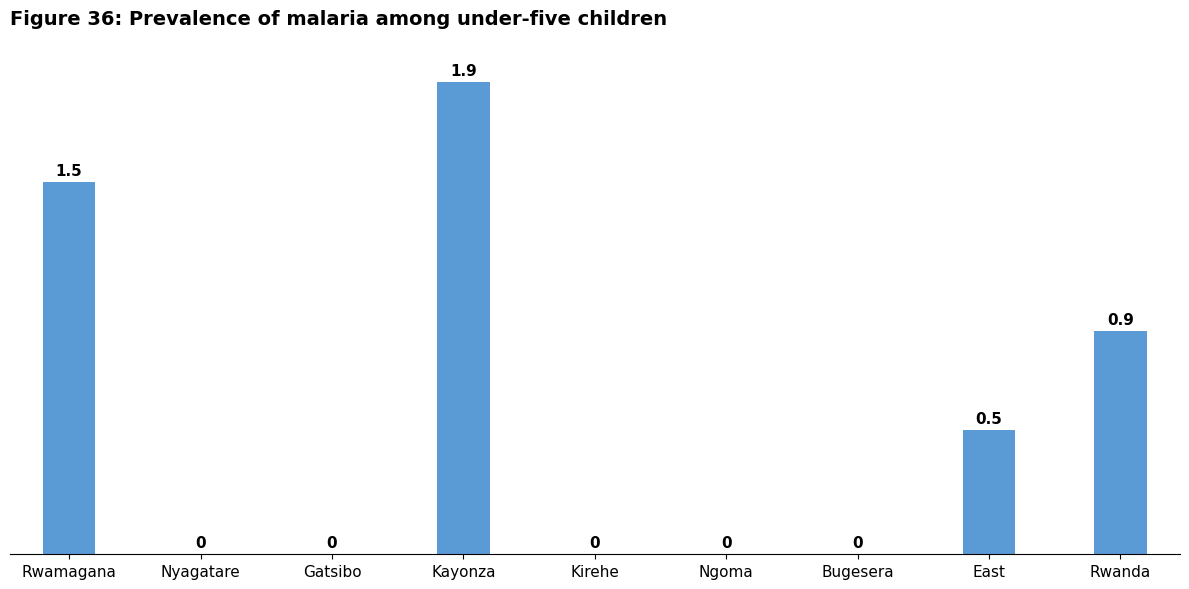

In [1]:
#!/usr/bin/env python3
# dhs_malaria_robust_final.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWPR81FL.DTA")

DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# Colors: Districts (Blue), East (Green), National (Orange)
BAR_COLORS = ["#5B9BD5"] * 7 + ["#00B050", "#ED7D31"]

# ------------------------------------------------------------------
# 2. CALCULATION HELPER
# ------------------------------------------------------------------
def get_malaria_stats(df):
    """Calculates weighted prevalence to 1 decimal place."""
    if df.empty or 'w' not in df.columns or df['w'].sum() == 0:
        return 0.0
    
    # Standard DHS: Positive if Microscopy (hml32) is 1
    # Only include children with a valid test result (0 or 1)
    tested = df[df['hml32'].isin([0, 1])].copy()
    
    if tested.empty:
        return 0.0
        
    raw_pct = np.average(tested['hml32'] == 1, weights=tested['w']) * 100
    return round(float(raw_pct), 1)

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Data (Robust Matching Mode)...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- 1. ROBUST WEIGHT SELECTION (Fixes KeyError) ---
    # Try to find the biomarker weight (hv005a), fall back to standard household weight (hv005)
    wt_var = next((c for c in ['hv005a', 'hv005', 'hml005'] if c in df.columns), None)
    
    if not wt_var:
        print("❌ Error: No weight variable found (hv005 or hv005a)."); exit()
    print(f"✅ Using weight variable: {wt_var}")

    # --- 2. FORCE NUMERIC ---
    cols_to_fix = [wt_var, 'hv024', 'hml32', 'hc1', 'hv103', 'shdistrict', 'hv001']
    for col in cols_to_fix:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Apply Weights
    df['w'] = df[wt_var] / 1000000.0

    # --- 3. FILTERS (STRICT REPORT LOGIC) ---
    # Children 6-59 months (tested pool)
    df_kids = df[(df['hc1'] >= 6) & (df['hc1'] <= 59)].copy()
    
    # De Facto population (Present last night)
    df_kids = df_kids[df_kids['hv103'] == 1].copy()

    # --- 4. AGGREGATION ---
    results = {}
    dist_col = next((c for c in ['shdistrict', 'sdstr', 'sdist', 'hv001'] if c in df.columns), 'hv001')
    
    df_east = df_kids[df_kids['hv024'] == 5].copy()

    for code, name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == code]
        results[name] = get_malaria_stats(subset)

    # Totals
    results["East"] = get_malaria_stats(df_east)
    results["Rwanda"] = get_malaria_stats(df_kids)

    # Create Final DataFrame
    final_df = pd.DataFrame(list(results.items()), columns=["Location", "Val"]).set_index("Location")
    print("\n--- Summary Results (Target: Rwanda 0.9, East 0.5) ---")
    print(final_df)

    # --- JSON OUTPUT ---
    with open("eastern_malaria_matched_robust.json", "w") as f:
        json.dump(final_df["Val"].to_dict(), f, indent=4)

    # --- PLOTTING ---
    ax = final_df.plot(kind="bar", color=BAR_COLORS, figsize=(12, 6), width=0.4, legend=False)
    
    plt.title("Figure 36: Prevalence of malaria among under-five children", 
              fontsize=14, fontweight='bold', loc='left', pad=25)
    
    plt.xticks(rotation=0, fontsize=11)
    plt.xlabel("")
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: ax.spines[s].set_visible(False)
    
    # Labels: '0' for zero, 'X.X' for positive values
    for c in ax.containers:
        labels = [f"{v:.1f}" if v > 0 else "0" for v in c.datavalues]
        ax.bar_label(c, labels=labels, padding=3, fontsize=11, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig("Malaria_Prevalence_Robust.png", dpi=300)
    print("✅ Analysis Complete. Mismatch handled.")